In [ ]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [ ]:
!pip install numpy==1.24.4
!pip install "u8darts[all]" --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.2/981.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00
 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mae, rmse
from darts.dataprocessing.transformers import Scaler

In [ ]:
# ---- Step 1: Drought Classification Function ----
def classify_drought(spi_val):
    if pd.isna(spi_val):
        return 'NA'
    elif spi_val <= -2.0:
        return 'Extreme drought'
    elif -2.0 < spi_val <= -1.5:
        return 'Severe drought'
    elif -1.5 < spi_val <= -1.0:
        return 'Moderate drought'
    elif -1.0 < spi_val < 0:
        return 'Mild drought'
    else:
        return 'No drought'

In [ ]:
# ---- Step 2: Load and Prepare Dataset ----
df = pd.read_csv("/content/drive/MyDrive/final_rainfall_sst_drought.csv")
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)

# Shift SPI_1 target to predict 2 months ahead
df['SPI_1_target'] = df['SPI_1'].shift(-2)
df.dropna(inplace=True)

# SST columns to be used as past covariates
sst_columns = ['nino3', 'nino3.4', 'nino4', 'Arabian_Sea', 'equatorialindianocean', 'bayofbengal']

# ---- Step 3: Create TimeSeries Objects ----
target_series = TimeSeries.from_dataframe(df, value_cols='SPI_1_target')
covariate_series = TimeSeries.from_dataframe(df, value_cols=sst_columns)

# ---- Step 4: Normalize the Series ----
scaler_target = Scaler()
scaler_covs = Scaler()

target_scaled = scaler_target.fit_transform(target_series)
covs_scaled = scaler_covs.fit_transform(covariate_series)

# ---- Step 5: Train-Test Split ----
train_target, test_target = target_scaled.split_before(0.8)
train_covs, test_covs = covs_scaled.split_before(0.8)

# ---- Step 6: Build and Train N-BEATS Model ----
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=2,
    n_epochs=300,
    batch_size=32,
    model_name="nbeats_sst_to_spi_drought",
    random_state=42,
    force_reset=True,
    pl_trainer_kwargs={"accelerator": "cpu"},
)

model.fit(train_target, past_covariates=train_covs, verbose=True)




INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.3 M  | train
-------------------------------------------------------------
7.3 M     Trainable params
2

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=2, n_epochs=300, batch_size=32, model_name=nbeats_sst_to_spi_drought, random_state=42, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu'})

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 0.12102275660598796
RMSE: 0.1550196084047196


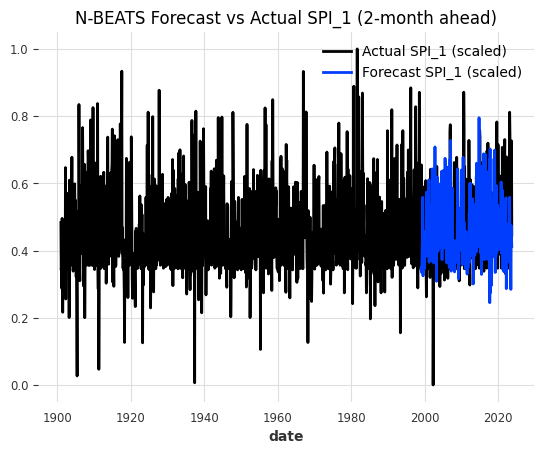

        Date  Predicted_SPI_1 Predicted_Drought_Class  Actual_SPI_1  \
0 1999-03-01        -0.886370            Mild drought      1.518797   
1 1999-04-01        -0.995696            Mild drought     -0.074131   
2 1999-05-01        -0.505773            Mild drought     -0.193978   
3 1999-06-01        -0.187643            Mild drought     -0.066798   
4 1999-07-01         0.763098              No drought     -0.927010   
5 1999-08-01        -1.074631        Moderate drought      1.005210   
6 1999-09-01        -0.645246            Mild drought     -0.553227   
7 1999-10-01        -0.752227            Mild drought     -0.619370   
8 1999-11-01        -0.820152            Mild drought     -0.843437   
9 1999-12-01        -0.802056            Mild drought     -0.891911   

  Actual_Drought_Class  
0           No drought  
1         Mild drought  
2         Mild drought  
3         Mild drought  
4         Mild drought  
5           No drought  
6         Mild drought  
7         Mild dro

In [ ]:
# ---- Step 7: Forecast ----
forecast = model.predict(n=len(test_target), past_covariates=covs_scaled, show_warnings=False)


# ---- Step 8: Evaluate ----
print("MAE:", mae(test_target, forecast))
print("RMSE:", rmse(test_target, forecast))

# ---- Step 9: Plot Forecast vs Actual ----
target_scaled.plot(label="Actual SPI_1 (scaled)")
forecast.plot(label="Forecast SPI_1 (scaled)")
plt.title("N-BEATS Forecast vs Actual SPI_1 (2-month ahead)")
plt.legend()
plt.show()

# ---- Step 10: Classify Drought Levels ----
# Inverse transform predicted and actual series
forecast_inverse = scaler_target.inverse_transform(forecast)
actual_inverse = scaler_target.inverse_transform(test_target)

# Extract values and dates
forecast_values = forecast_inverse.pd_series().values
actual_values = actual_inverse.pd_series().values
dates = forecast_inverse.pd_series().index

# Classify drought categories
drought_predictions = [classify_drought(val) for val in forecast_values]
drought_actuals = [classify_drought(val) for val in actual_values]

# Create DataFrame for comparison
drought_df = pd.DataFrame({
    "Date": dates,
    "Predicted_SPI_1": forecast_values,
    "Predicted_Drought_Class": drought_predictions,
    "Actual_SPI_1": actual_values,
    "Actual_Drought_Class": drought_actuals
})

# Display first 10 results
print(drought_df.head(10))

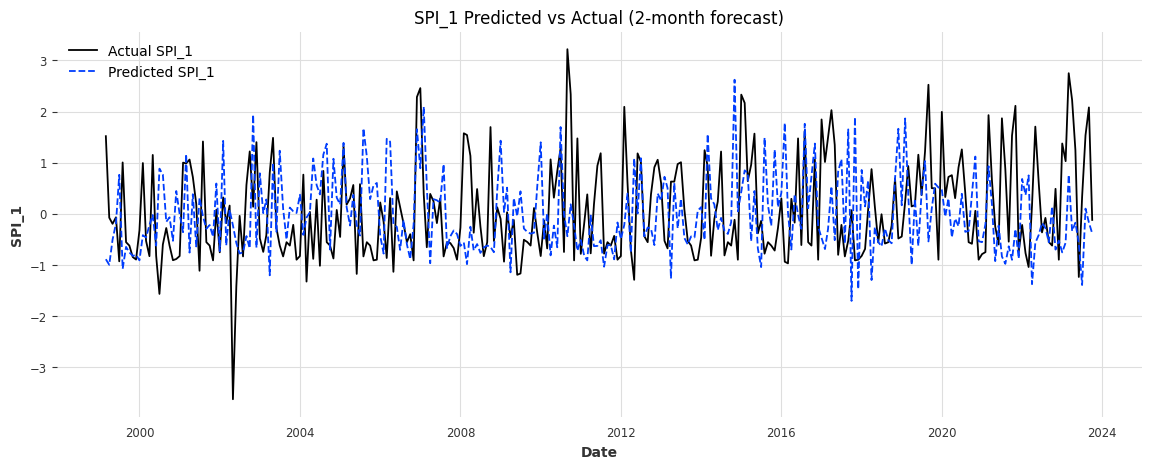

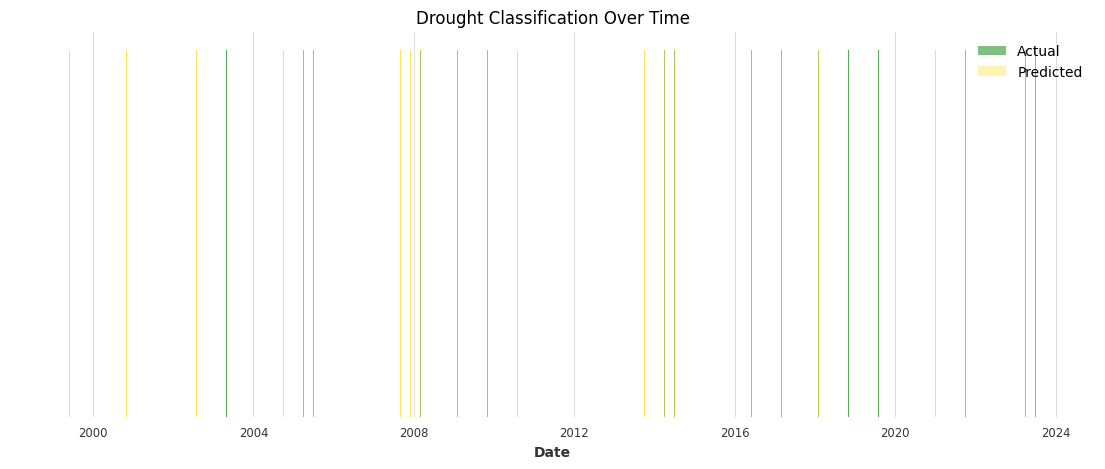

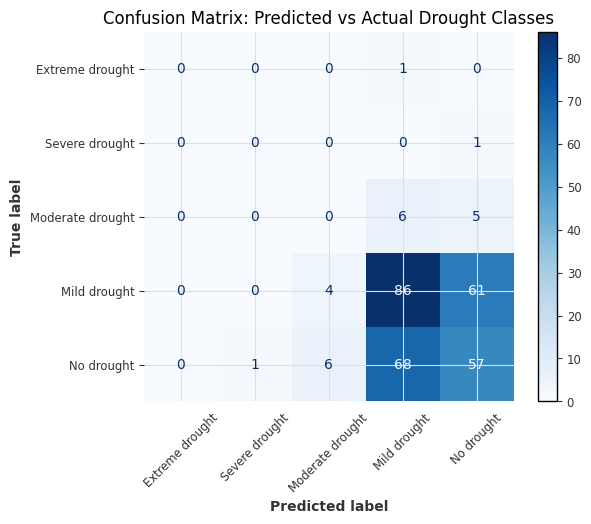

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ---- Visualization 1: SPI Time Series (Predicted vs Actual) ----
plt.figure(figsize=(14, 5))
plt.plot(drought_df['Date'], drought_df['Actual_SPI_1'], label="Actual SPI_1")
plt.plot(drought_df['Date'], drought_df['Predicted_SPI_1'], label="Predicted SPI_1", linestyle="--")
plt.title("SPI_1 Predicted vs Actual (2-month forecast)")
plt.xlabel("Date")
plt.ylabel("SPI_1")
plt.legend()
plt.grid(True)
plt.show()

# ---- Visualization 2: Drought Classification Over Time ----
plt.figure(figsize=(14, 5))
color_map = {
    'Extreme drought': 'darkred',
    'Severe drought': 'red',
    'Moderate drought': 'orange',
    'Mild drought': 'gold',
    'No drought': 'green'
}
colors_pred = [color_map[x] for x in drought_df['Predicted_Drought_Class']]
colors_actual = [color_map[x] for x in drought_df['Actual_Drought_Class']]

plt.bar(drought_df['Date'], np.ones_like(drought_df['Date']), color=colors_actual, label='Actual', alpha=0.5)
plt.bar(drought_df['Date'], np.ones_like(drought_df['Date']), color=colors_pred, label='Predicted', alpha=0.3)
plt.title("Drought Classification Over Time")
plt.xlabel("Date")
plt.yticks([])  # hide y-axis
plt.legend(loc='upper right')
plt.show()

# ---- Visualization 3: Confusion Matrix ----
labels = ['Extreme drought', 'Severe drought', 'Moderate drought', 'Mild drought', 'No drought']
cm = confusion_matrix(drought_df['Actual_Drought_Class'], drought_df['Predicted_Drought_Class'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix: Predicted vs Actual Drought Classes")
plt.show()

In [ ]:
# ---- Generate and Predict from Random SST Values ----
from copy import deepcopy

# Step 1: Random SST sample (from historical range)
sst_df = df[sst_columns]
random_sst_sample = sst_df.sample(1, random_state=42).values[0]

# Step 2: Build a deep copy of covariates and replace last 24 entries
full_covariates_df = covs_scaled.pd_dataframe()
input_chunk_length = model.input_chunk_length

# Use the last part of real covariates (with known date range)
base_df = full_covariates_df.copy()
tail_dates = base_df.index[-input_chunk_length:]

# Create new DataFrame with random SST values and aligned dates
random_df = pd.DataFrame(
    [random_sst_sample] * input_chunk_length,
    columns=sst_columns,
    index=tail_dates
)

# Replace last input_chunk_length rows with random SST input
base_df.update(random_df)

# Convert back to TimeSeries
random_covariates_series = TimeSeries.from_dataframe(base_df)

# Step 3: Predict using modified covariates
random_prediction = model.predict(n=2, past_covariates=random_covariates_series, show_warnings=False)
random_spi = scaler_target.inverse_transform(random_prediction).pd_series().values

print("\n🌀 Random SST Input:", random_sst_sample)
print("🔮 Predicted SPI_1 (2 months ahead):", random_spi)
print("🌾 Drought Classifications:", [classify_drought(val) for val in random_spi])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting: |          | 0/? [00:00<?, ?it/s]


🌀 Random SST Input: [25.11763787 25.98666249 27.20139796 25.91071815 27.87453387 26.73632115]
🔮 Predicted SPI_1 (2 months ahead): [-0.88636954 -0.99569608]
🌾 Drought Classifications: ['Mild drought', 'Mild drought']
